# DDPM 실습 파이토치편


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

from tqdm import tqdm
import plotly.graph_objects as go



- 사용하는 데이터 셋은 deeplearning.ai에서 제공하는 숏코스 [How Diffusion Models Work](https://www.deeplearning.ai/short-courses/)에서 사용하는 16x16 크기를 가지는 이미지 스프라이트입니다.  

In [ ]:
# 사용 디바이스 세팅
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 데이터 셋 준비

가정 먼저 준비된 데이터 셋 파일을 다운 받습니다.

In [ ]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
!gdown 1gAY7uXhe6jBRv0NMk7iXWKRln-nPjo4s

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:01<00:00, 60.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gAY7uXhe6jBRv0NMk7iXWKRln-nPjo4s
To: /content/sprite_labels_nc_1788_16x16.npy
100% 3.58M/3.58M [00:00<00:00, 144MB/s]


데이터 파일이 넘파이 어레이로 구성되어 있으므로 `np.load()`로 로딩합니다.

In [ ]:
sprites = np.load('sprites_1788_16x16.npy')
sprite_labels = np.load('sprite_labels_nc_1788_16x16.npy').astype(np.float32)

데이터 셋은 넘파이 어레이이며 데이터 셋의 모양과 각 샘플의 최솟값, 최댓값을 확인해보면 개별 샘플은 모양이 (16,16,3)이고 0에서 255값을 가지는 이미지 어레이라는 것을 알 수 있습니다.

In [ ]:
sprites.shape, sprites.min(), sprites.max()

((89400, 16, 16, 3), 0, 255)

In [ ]:
sprite_labels.shape, sprite_labels.dtype

((89400, 5), dtype('float32'))

이미지의 크기와 채널수를 설정합니다.

In [ ]:
H = 16
W = 16
C = 3
CTX_LEN = 5

### 노이즈 스케쥴러 정의 및 적용

이미지를 한장씩 반환하는 데이터셋 클래스 `MyDataset`을 정의 합니다. 데이터셋 내부에서 이미지에 대한 일련의 `transform`을 적용하고 나서 노이즈 추가을 진행하기 위해 식(4)에서 사용하는 $\beta_t$, $\alpha_t$, $\bar\alpha_t$를 클래스 변수로 계산해 둡니다.

In [ ]:
class MyDataset(Dataset):
    # beta는 DDPM 원문의 설정을 따르고
    beta_1 = 1e-4
    beta_T = 0.02
    # 시간 단계는 deeplearning.ai에서 제공하는 숏코스 How Diffusion Models Work의 설정을 따름
    T = 500

    # beta는 첨자 1부터 T까지 사용하기 위해 제일 앞에 더미 데이터 tf.constant([0.])를 추가하여 만듬
    beta = torch.cat([ torch.tensor([0]), torch.linspace(beta_1, beta_T, T)], axis=0)
    alpha = 1 - beta
    alpha_bar = torch.exp(torch.cumsum(torch.log(alpha), axis=0))

    labels = ['hero', 'non-hero', 'food', 'spell', 'side-facing']

    def __init__(self, data, ctx, transform=None):
        self.data = data
        self.transform = transform
        self.ctx = ctx

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]
        ctx = self.ctx[i]
        label = MyDataset.labels[np.argmax(ctx)]

        # normalize -1~1로 만들기
        if self.transform:
            x_0 = self.transform(x_0)

        # noise 추가
        t = np.random.randint(1, MyDataset.T+1)
        eps = torch.randn_like(x_0)
        x_t = torch.sqrt(MyDataset.alpha_bar[t]) * x_0 + torch.sqrt(1 - MyDataset.alpha_bar[t]) * eps

        return x_0, x_t, eps, t, ctx, label

이미지 픽셀값을 -1~1사이로 변환하는 `transform`을 구성하고 데이터 셋을 생성합니다. 계속해서 생성된 데이터 셋을 이용하는 데이터 로더도 준비합니다. 배치사이즈는 텐서플로 구현과 같게 64로 지정합니다.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

train_ds = MyDataset(sprites, sprite_labels, transform)

m = 64

train_loader = DataLoader(train_ds, batch_size=m, shuffle=True)
train_loader_iter = iter(train_loader)

데이터 로더로 부터 미니배치를 받아와 그림을 그려봅니다.

In [ ]:
samples = next(train_loader_iter)

x_0s = samples[0][:6].numpy()
x_ts = samples[1][:6].numpy()
epss = samples[2][:6].numpy()
ts =  samples[3][:6].numpy()
ctx = samples[4][:6].numpy()
labels = samples[5][:6]

In [ ]:
ctx, labels

(array([[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], dtype=float32),
 ('non-hero', 'spell', 'spell', 'non-hero', 'non-hero', 'side-facing'))

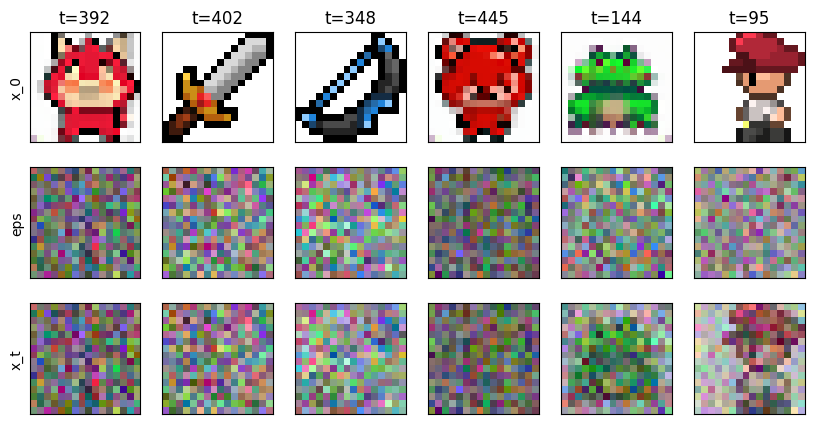

In [ ]:
fig, axs = plt.subplots(figsize=(10,5), nrows=3, ncols=6)

i = 0
for (x_0, x_t, eps, t) in zip(x_0s, x_ts, epss, ts):
    x_0 = x_0.transpose(1,2,0)
    x_0 = ((x_0 - x_0.min()) / (x_0.max() - x_0.min())).clip(0,1)
    axs[0][i].imshow(x_0)
    axs[0][i].set_title(f"t={t}")
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])

    eps = eps.transpose(1,2,0)
    eps = ((eps - eps.min()) / (eps.max() - eps.min())).clip(0,1)
    axs[1][i].imshow(eps)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])

    x_t = x_t.transpose(1,2,0)
    x_t = ((x_t - x_t.min()) / (x_t.max() - x_t.min())).clip(0,1)
    axs[2][i].imshow(x_t)
    axs[2][i].set_xticks([])
    axs[2][i].set_yticks([])

    if i == 0:
        axs[0][i].set_ylabel('x_0')
        axs[1][i].set_ylabel('eps')
        axs[2][i].set_ylabel('x_t')

    i += 1

plt.show()

그림을 확인해보면 샘플 중 앞 여섯개에 임의의 시간 단계에 대한 노이즈가 적용되는 것을 알 수 있습니다. 첫 행은 원본 이미지, 둘째 행은 적용될 노이즈, 셋째 행은 노이즈가 적용된 모습을 나타냅니다. 시간 단계가 작을 수록 원본 이미지가 남아있고 200이 넘어가면 거의 알아볼 수 없게 될 것입니다.

만들어진 데이터 셋에 셔플과 배치사이즈를 적용합니다.

## 모델 만들기





이제 모델을 정의 합니다. 가능하다면 (3,16,16) 크기의 이미지를 (768,) 크기의 벡터로 펼친 다음 완전 연결 네트워크로만 구성하고 싶었지만 실험 결과 이런 MLP 구조로는 의미있는 결과를 만들 수 없었습니다. 따라서 conv 레이어를 가지는 간단한 네트워크를 사용합니다. 원문에는 Unet 구조를 사용한다고 되어있지만 Unet도 복잡하기 때문에 Unet 특징이 약간 들어있는 아래 그림과 같은 네트워크를 사용하겠습니다.

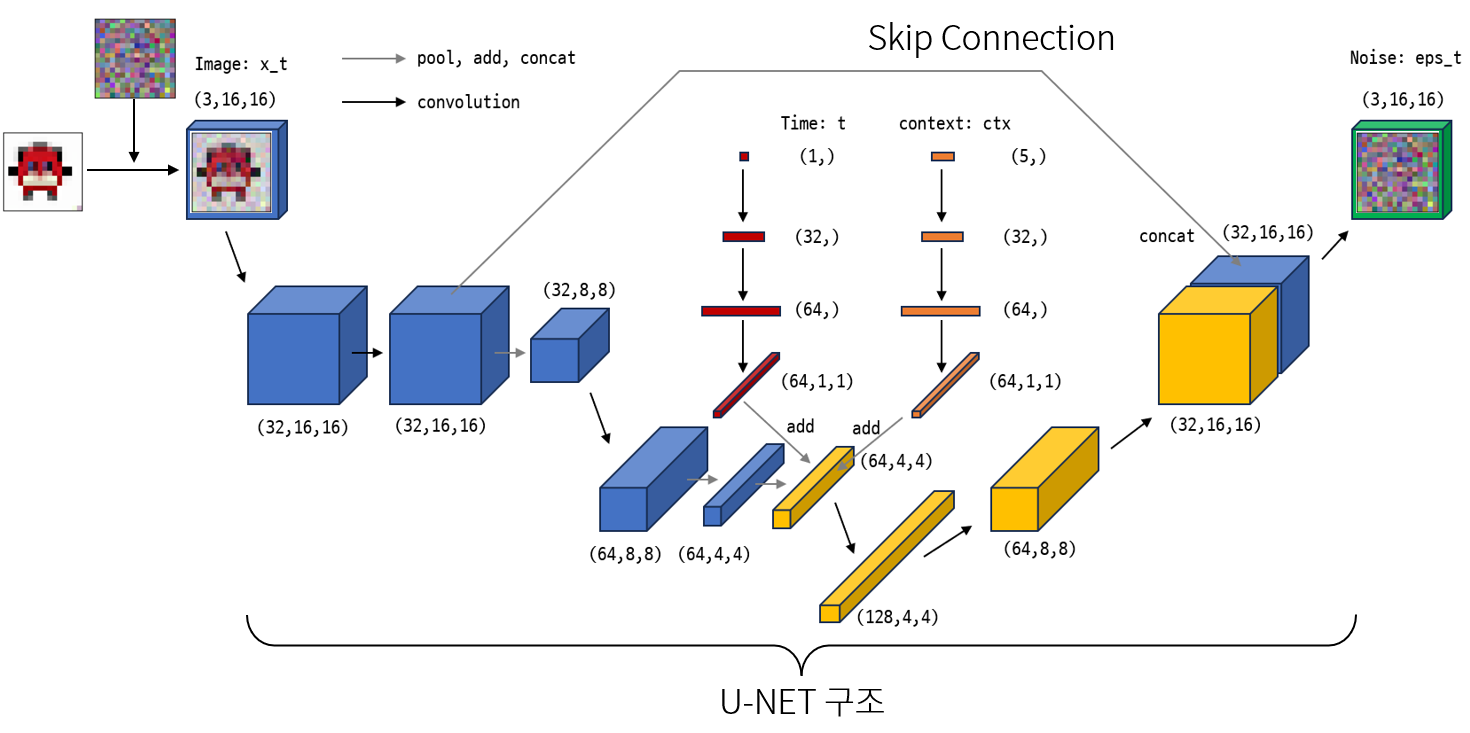

네트워크 구조는 매우 간단하여 그림과 아래 코드를 함께 보면 금방 이해가 갈 것입니다. 네트워크의 특징을 다음으로 요약할 수 있습니다.

- 이미지에 Conv레이어를 몇번 적용하여 만들어진 특징 맵과 시간 단계에 Dense 레이어를 몇번 적용한 임베딩 벡터를 중간쯤에서 더하여 두 입력을 모두 반영하는 특징 맵을 만듭니다.

- 특징 맵을 다시 이미지 모양으로 디코딩할 때 인코딩 과정에서 만들어 둔 특징 맵과 연결시키는 스킵 커넥션 구조를 한번 사용합니다.

In [ ]:
class DDPM(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.t_emb_1 = torch.nn.Linear(in_features=1, out_features=32)
        self.t_emb_2 = torch.nn.Linear(in_features=32, out_features=64)

        self.ctx_emb_1 = torch.nn.Linear(in_features=CTX_LEN, out_features=32)
        self.ctx_emb_2 = torch.nn.Linear(in_features=32, out_features=64)

        self.down_conv1_32 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.down_conv2_32 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.down_conv3_64 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.down_conv4_128 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.up_conv1_64 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.up_conv2_32 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.up_conv3_32 = torch.nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)

        self.relu = torch.nn.ReLU()
        self.gelu = torch.nn.GELU()

    def forward(self, x, t, ctx):
        # x: (N, C, H, W)
        # t: (N,1)
        batch_size = t.shape[0]

        # time embedding
        t = self.relu( self.t_emb_1(t) ) # (N, 32)
        t = self.relu( self.t_emb_2(t) ) # (N, 64)
        t = t.reshape(batch_size, -1, 1, 1) # (N, 64, 1, 1)

        # context embedding
        ctx = self.relu( self.ctx_emb_1(ctx) ) # (N, 32)
        ctx = self.relu( self.ctx_emb_2(ctx) ) # (N, 64)
        ctx = ctx.reshape(batch_size, -1, 1, 1) # (N, 64, 1, 1)

        # image down conv
        x = self.gelu( self.down_conv1_32(x) )    # (N, 32, 16, 16)
        x_32 = self.gelu( self.down_conv2_32(x) ) # (N, 32, 16, 16)
        size_32 = x_32.shape
        x = torch.nn.functional.max_pool2d(x_32, (2,2)) # (N, 32, 8, 8)
        x = self.gelu( self.down_conv3_64(x) ) # (N, 64, 8, 8)
        size_64 = x.shape
        x = torch.nn.functional.max_pool2d(x, (2,2)) # (N, 64, 4, 4)

        x = x + t + ctx # (N, 64, 4, 4) + (N, 64, 1, 1) + (N, 64, 1, 1) = (N, 64, 4, 4)
        x = self.gelu( self.down_conv4_128(x) ) # (N, 128, 4, 4)

        # image up conv
        x = self.gelu( self.up_conv1_64(x, output_size=size_64) ) # (N, 64, 8, 8)
        x = self.gelu( self.up_conv2_32(x, output_size=size_32) ) # (N, 32, 16, 16)
        x = torch.concat([x, x_32], axis=1) # (N, 64, 16, 16)
        out = self.up_conv3_32(x) # (N, 3, 16, 16)

        return out


모델을 만들고 사용 다바이스로 모델을 이동시킵니다.

In [ ]:
model = DDPM()
model.to(device)

DDPM(
  (t_emb_1): Linear(in_features=1, out_features=32, bias=True)
  (t_emb_2): Linear(in_features=32, out_features=64, bias=True)
  (ctx_emb_1): Linear(in_features=5, out_features=32, bias=True)
  (ctx_emb_2): Linear(in_features=32, out_features=64, bias=True)
  (down_conv1_32): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_conv2_32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_conv3_64): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_conv4_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up_conv1_64): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up_conv2_32): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (up_conv3_32): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (gelu): GELU(approximate='none')
)

모델을 완성했으면 앞서 만들어둔 데이터 셋을 이용해 포워드 테스트를 해봐야 합니다. 배치 사이즈 64이므로 한 배치를 네트워크에 입력하면 출력으로 (64,3,16,16)이 나와야 합니다.

In [ ]:
output = model(
    samples[0].to(device), # image
    samples[3].reshape(-1,1).float().to(device), # time
    samples[4].to(device) # context
)

print(output.shape)

torch.Size([64, 3, 16, 16])


포워드 테스트가 성공했으므로 이제 학습 시키는 일만 남았습니다.

## 학습



$$
L_{\text{simple}}(\theta) := \mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}} \left[ \left\lVert \boldsymbol{\epsilon}- \boldsymbol{\epsilon}_\theta(\sqrt{\bar\alpha_t}\mathbf{x}_0 + \sqrt{1-\bar\alpha_t}\boldsymbol{\epsilon}, t) \right\rVert^2_2 \right] \tag{14}
$$

위 손실 함수는 모든 샘플과 시간 단계에 대해서 MSE 손실 함수를 사용한다는 것을 의미합니다. 손실 함수를 식(14)처럼 MSE로 설정하고 적당한 옵티마이저를 생성합니다.

In [ ]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

다음은 학습 루프를 구현할 차례입니다.

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_training.png" style="width: 60%;" alt="ddpm algorithm1 Trainning">

위 그림에 나타난 학습 알고리즘을 직접 구현합니다. 학습 루프에서 `mae` 매트릭도 함께 계산해서 화면에 출력해 줍니다.



In [ ]:
epochs = 30
losses = []

for e in range(epochs):
    epoch_loss = 0.0
    epoch_mae = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        x_0, x_t, eps, t, ctx, label = data
        x_t = x_t.to(device)
        eps = eps.to(device)
        t = t.to(device)
        ctx = ctx.to(device)

        optimizer.zero_grad()
        eps_theta = model(x_t, t.reshape(-1,1).float(), ctx)
        loss = loss_func(eps_theta, eps)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()
            epoch_mae += torch.nn.functional.l1_loss(eps_theta, eps)

    epoch_loss /= len(train_loader)
    epoch_mae /= len(train_loader)

    print(f"Epoch: {e+1:2d}: loss:{epoch_loss:.4f}, mae:{epoch_mae:.4f}")
    losses.append(epoch_loss)

100%|██████████| 1397/1397 [00:36<00:00, 38.32it/s]


Epoch:  1: loss:0.3868, mae:0.4532


100%|██████████| 1397/1397 [00:31<00:00, 44.87it/s]


Epoch:  2: loss:0.2452, mae:0.3514


100%|██████████| 1397/1397 [00:29<00:00, 47.29it/s]


Epoch:  3: loss:0.2026, mae:0.3105


100%|██████████| 1397/1397 [00:30<00:00, 46.25it/s]


Epoch:  4: loss:0.1841, mae:0.2920


100%|██████████| 1397/1397 [00:29<00:00, 47.47it/s]


Epoch:  5: loss:0.1729, mae:0.2794


100%|██████████| 1397/1397 [00:29<00:00, 47.40it/s]


Epoch:  6: loss:0.1630, mae:0.2685


100%|██████████| 1397/1397 [00:29<00:00, 47.24it/s]


Epoch:  7: loss:0.1551, mae:0.2600


100%|██████████| 1397/1397 [00:29<00:00, 47.50it/s]


Epoch:  8: loss:0.1513, mae:0.2554


100%|██████████| 1397/1397 [00:29<00:00, 46.58it/s]


Epoch:  9: loss:0.1471, mae:0.2508


100%|██████████| 1397/1397 [00:28<00:00, 48.23it/s]


Epoch: 10: loss:0.1443, mae:0.2478


100%|██████████| 1397/1397 [00:29<00:00, 47.74it/s]


Epoch: 11: loss:0.1419, mae:0.2449


100%|██████████| 1397/1397 [00:30<00:00, 46.53it/s]


Epoch: 12: loss:0.1396, mae:0.2422


100%|██████████| 1397/1397 [00:29<00:00, 46.75it/s]


Epoch: 13: loss:0.1384, mae:0.2409


100%|██████████| 1397/1397 [00:30<00:00, 45.31it/s]


Epoch: 14: loss:0.1361, mae:0.2382


100%|██████████| 1397/1397 [00:30<00:00, 46.29it/s]


Epoch: 15: loss:0.1340, mae:0.2361


100%|██████████| 1397/1397 [00:30<00:00, 45.43it/s]


Epoch: 16: loss:0.1336, mae:0.2351


100%|██████████| 1397/1397 [00:30<00:00, 46.56it/s]


Epoch: 17: loss:0.1324, mae:0.2339


100%|██████████| 1397/1397 [00:30<00:00, 45.60it/s]


Epoch: 18: loss:0.1305, mae:0.2317


100%|██████████| 1397/1397 [00:29<00:00, 46.87it/s]


Epoch: 19: loss:0.1292, mae:0.2305


100%|██████████| 1397/1397 [00:29<00:00, 46.83it/s]


Epoch: 20: loss:0.1285, mae:0.2295


100%|██████████| 1397/1397 [00:29<00:00, 48.09it/s]


Epoch: 21: loss:0.1272, mae:0.2282


100%|██████████| 1397/1397 [00:29<00:00, 48.10it/s]


Epoch: 22: loss:0.1274, mae:0.2282


100%|██████████| 1397/1397 [00:30<00:00, 46.43it/s]


Epoch: 23: loss:0.1264, mae:0.2269


100%|██████████| 1397/1397 [00:29<00:00, 47.43it/s]


Epoch: 24: loss:0.1252, mae:0.2259


100%|██████████| 1397/1397 [00:30<00:00, 46.23it/s]


Epoch: 25: loss:0.1242, mae:0.2246


100%|██████████| 1397/1397 [00:29<00:00, 47.99it/s]


Epoch: 26: loss:0.1242, mae:0.2241


100%|██████████| 1397/1397 [00:29<00:00, 48.14it/s]


Epoch: 27: loss:0.1226, mae:0.2228


100%|██████████| 1397/1397 [00:29<00:00, 46.85it/s]


Epoch: 28: loss:0.1228, mae:0.2229


100%|██████████| 1397/1397 [00:28<00:00, 48.40it/s]


Epoch: 29: loss:0.1219, mae:0.2219


100%|██████████| 1397/1397 [00:29<00:00, 47.98it/s]

Epoch: 30: loss:0.1211, mae:0.2208


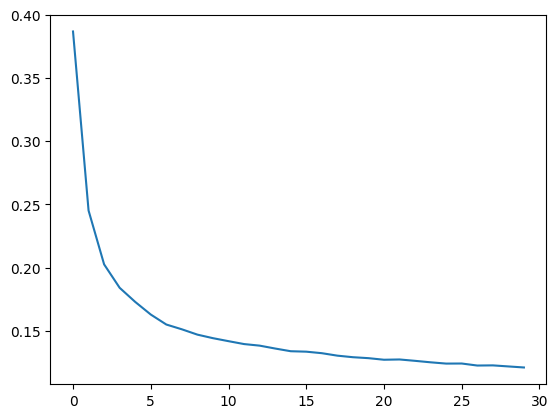

In [ ]:
plt.plot(losses)
plt.show()

## 샘플링

<img src="https://raw.githubusercontent.com/metamath1/imgs/main/diffusion/alg_sampling.png" style="width: 60%;" alt="ddpm algorithm2 Sampling">

학습된 모델을 이용해서 샘플링 알고리즘을 따라 모든 시간 단계에 대한 샘플을 샘플링합니다.

샘플링 과정에서 사용할  $\beta_t$, $\alpha_t$, $\bar\alpha_t$를 클래스 외부 변수로 빼둡니다.

In [ ]:
alpha = MyDataset.alpha.to(device)
alpha_bar = MyDataset.alpha_bar.to(device)
beta = MyDataset.beta.to(device)
T = MyDataset.T

In [ ]:
# 샘플링 단계동안 생성된 이미지를 일정 간격마다 저장할 리스트를 준비
interval = 20 # 20 시간 단계마다 한장씩 생성 결과 기록
X = [] # 생성 이미지 저장
saved_frame = [] # 이미지를 저장한 시간 단계를 저장
N = 5 # 모델에 입력할 샘플 개수

# 최초 노이즈 샘플링
x = torch.randn(size=(N, C, H, W)).to(device)
# context
ctx = F.one_hot(torch.randint(0, 5, (N,)), 5).to(device=device).float()

for t in range(T, 0, -1):
    if t > 1:
        z = torch.randn(size=(N,C,H,W)).to(device)
    else:
        z = torch.zeros((N,C,H,W)).to(device)

    t_torch = torch.tensor([[t]]*N, dtype=torch.float32).to(device)

    eps_theta = model(x, t_torch, ctx)

    x = (1 / torch.sqrt(alpha[t])) * \
        (x - ((1-alpha[t])/torch.sqrt(1-alpha_bar[t]))*eps_theta) + torch.sqrt(beta[t])*z

    if (T - t) % interval == 0  or t == 1:
        # 현재 시간 단계로 부터 생성되는 t-1번째 이미지를 저장
        saved_frame.append(t)
        x_np = x.detach().cpu().numpy()

        # (N,C,H,W)->(H,N,W,C)
        x_np = x_np.transpose(2,0,3,1).reshape(H,-1,C)
        x_np = ((x_np - x_np.min()) / (x_np.max() - x_np.min())).clip(0,1)
        X.append( x_np*255.0 ) # 0 ~ 1 -> 0 ~ 255

X = np.array(X, dtype=np.uint8)

샘플링 과정동안 수집한 이미지를 애니메이션으로 표현합니다.

`plotly`로 애니메이션을 표시하는 예제 코드는 이곳 [https://plotly.com/python/animations/](https://plotly.com/python/animations/)과 이곳 [https://plotly.com/python/imshow/](https://plotly.com/python/imshow/)을 참고 하여 작성하였습니다.

In [ ]:
fig = go.Figure(
    data = [ go.Image(z=X[0]) ],
    layout = go.Layout(
        # title="Generated image",
        autosize = False,
        width = 800, height = 400,
        margin = dict(l=0, r=0, b=0, t=30),
        xaxis = {"title": f"Generated Image: x_{T-1}"},
        updatemenus = [
            dict(
                type="buttons",
                buttons=[
                    # play button
                    dict(
                        label="Play", method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 50, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 50, "easing": "quadratic-in-out"}
                            }
                        ]
                    ),
                    # pause button
                    dict(
                        label="Pause", method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ]
                    )
                ],
                direction="left", pad={"r": 10, "t": 87}, showactive=False,
                x=0.1, xanchor="right", y=0, yanchor="top"
            )
        ], # updatemenus = [
    ), # layout = go.Layout(
    frames = [
        {
            'data':[go.Image(z=X[t])],
            'name': t,
            'layout': {
                'xaxis': {'title': f"Generated Image: x_{saved_frame[t]-1}"}
            }
        } for t in range(len(X))
    ]
)

################################################################################
# 슬라이더 처리
sliders_dict = {
    "active": 0, "yanchor": "top", "xanchor": "left",
    "currentvalue": {
        "font": {"size": 15}, "prefix": "input time:",
        "visible": True, "xanchor": "right"
    },
    "transition": {"duration": 100, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9, "x": 0.1, "y": 0,
    "steps": []
}

for t in range(len(X)):
    slider_step = {
        "label": f"{saved_frame[t]}", "method": "animate",
        "args": [
            [t], # frame 이름과 일치해야 연결됨
            {
                "frame": {"duration": 100, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 100}
            }
        ],
    }

    sliders_dict["steps"].append(slider_step)

fig["layout"]["sliders"] = [sliders_dict]
################################################################################

fig.show()

In [ ]:
',  '.join(np.array(MyDataset.labels)[ctx.argmax(axis=1).cpu()])

'spell,  side-facing,  hero,  food,  side-facing'

위 그림에서 play를 누르거나 슬라이드 바를 이동 시키면 시간 단계에 따라 노이즈가 제거되는 이미지를 확인할 수 있습니다. 완전히 깨끗하고 정교하게 노이즈가 제거되진 않지만 무작위 노이즈로부터 게임 아이템과 캐릭터 처럼 생긴 물체들이 약 200단계에서부터 서서히 생겨나는것을 확인할 수 있습니다!

간단한 네트워크로 충분히 납득할만한 결과를 생성할 수 있었습니다. 이제 여러분들이 네트워크를 더 정교하게 다듬어 생생한 캐릭터 이미지를 생성하시기 바랍니다.



